Series de tiempo

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet

# =========================================
# 1. CARGA Y EXPLORACIÓN DEL DATASET
# =========================================

# Cargar dataset Air Passengers
data = get_rdataset('AirPassengers')
df_air = data.data

display(pd.DataFrame({
    'Dataset': ['AIR PASSENGERS'],
    'Período': ['Enero 1949 - Diciembre 1960'],
    'Observaciones': [f"{len(df_air)} registros mensuales"],
    'Variable': ['Número de pasajeros aéreos (en miles)'],
    'Fuente': ['statsmodels datasets']
}).style.set_caption("<h1>📊 DATASET: AIR PASSENGERS</h1>").hide(axis='index'))

# Preparar datos correctamente
df_air_prophet = df_air.copy()
df_air_prophet['year'] = df_air_prophet['time'].astype(int)
df_air_prophet['month_num'] = ((df_air_prophet['time'] - df_air_prophet['year']) * 12 + 1).astype(int)
df_air_prophet['ds'] = pd.to_datetime(
    df_air_prophet['year'].astype(str) + '-' + 
    df_air_prophet['month_num'].astype(str) + '-01'
)
df_air_prophet['y'] = df_air_prophet['value']
df_air_prophet = df_air_prophet[['ds', 'y']]

display(pd.DataFrame({
    'Primeros Registros': df_air_prophet.head(6)['y'].tolist(),
    'Fechas': df_air_prophet.head(6)['ds'].dt.strftime('%Y-%m').tolist(),
    'Últimos Registros': df_air_prophet.tail(6)['y'].tolist(),
    'Fechas Finales': df_air_prophet.tail(6)['ds'].dt.strftime('%Y-%m').tolist()
}).style.set_caption("<h2>📅 ESTRUCTURA DEL DATASET</h2>").hide(axis='index'))


Dataset,Período,Observaciones,Variable,Fuente
AIR PASSENGERS,Enero 1949 - Diciembre 1960,144 registros mensuales,Número de pasajeros aéreos (en miles),statsmodels datasets


Primeros Registros,Fechas,Últimos Registros,Fechas Finales
112,1949-01,622,1960-07
118,1949-01,606,1960-08
132,1949-03,508,1960-09
129,1949-04,461,1960-10
121,1949-04,390,1960-11
135,1949-06,432,1960-12


In [14]:
# =========================================
# 2. DIVISIÓN EN TRAIN/TEST
# =========================================

# Usaremos los últimos 12 meses (1 año) para test
train = df_air_prophet.iloc[:-12]   # Primeros 11 años para entrenamiento
test = df_air_prophet.iloc[-12:]    # Último año para prueba

display(pd.DataFrame({
    'Conjunto': ['ENTRENAMIENTO (Train)', 'PRUEBA (Test)'],
    'Período': [
        f"{train['ds'].min().strftime('%Y-%m')} a {train['ds'].max().strftime('%Y-%m')}",
        f"{test['ds'].min().strftime('%Y-%m')} a {test['ds'].max().strftime('%Y-%m')}"
    ],
    'Observaciones': [len(train), len(test)],
    'Porcentaje': [f"{(len(train)/len(df_air_prophet))*100:.1f}%", f"{(len(test)/len(df_air_prophet))*100:.1f}%"]
}).style.set_caption("<h2>🎯 DIVISIÓN TRAIN/TEST</h2>").hide(axis='index'))

Conjunto,Período,Observaciones,Porcentaje
ENTRENAMIENTO (Train),1949-01 a 1959-12,132,91.7%
PRUEBA (Test),1960-01 a 1960-12,12,8.3%


In [15]:
# =========================================
# 3. MODELADO CON PROPHET
# =========================================

# Entrenar modelo Prophet con estacionalidad anual
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)
m.fit(train)

# Crear dataframe futuro para predicciones
future = m.make_future_dataframe(periods=len(test), freq='M')
forecast = m.predict(future)

display(pd.DataFrame({
    'Modelo': ['Prophet con Estacionalidad Multiplicativa'],
    'Parámetros': ['yearly_seasonality=True, seasonality_mode=multiplicative'],
    'Período Entrenamiento': [f"{len(train)} meses (11 años)"],
    'Período Predicción': [f"{len(test)} meses (1 año)"],
    'Características Modeladas': ['Tendencia + Estacionalidad Anual Multiplicativa']
}).style.set_caption("<h2>🤖 CONFIGURACIÓN DEL MODELO PROPHET</h2>").hide(axis='index'))

23:34:03 - cmdstanpy - INFO - Chain [1] start processing
23:34:03 - cmdstanpy - INFO - Chain [1] done processing


Modelo,Parámetros,Período Entrenamiento,Período Predicción,Características Modeladas
Prophet con Estacionalidad Multiplicativa,"yearly_seasonality=True, seasonality_mode=multiplicative",132 meses (11 años),12 meses (1 año),Tendencia + Estacionalidad Anual Multiplicativa


In [17]:
# =========================================
# 4. EVALUACIÓN DEL MODELO
# =========================================

# Extraer predicciones para el período de test
y_true = test["y"].values
y_pred = forecast.iloc[-len(test):]["yhat"].values

# Calcular métricas
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

display(pd.DataFrame({
    'Métrica': ['MAE (Mean Absolute Error)', 'RMSE (Root Mean Squared Error)', 'MAPE (Mean Absolute Percentage Error)'],
    'Valor': [f"{mae:.2f}", f"{rmse:.2f}", f"{mape:.2f}%"],
    'Interpretación': [
        f'Error promedio: {mae:.0f} mil pasajeros',
        'Penaliza más los errores grandes',
        f'Error relativo: {mape:.1f}% del valor real'
    ]
}).style.set_caption("<h2>📊 MÉTRICAS DE EVALUACIÓN</h2>").hide(axis='index'))

Métrica,Valor,Interpretación
MAE (Mean Absolute Error),21.52,Error promedio: 22 mil pasajeros
RMSE (Root Mean Squared Error),23.94,Penaliza más los errores grandes
MAPE (Mean Absolute Percentage Error),4.49%,Error relativo: 4.5% del valor real


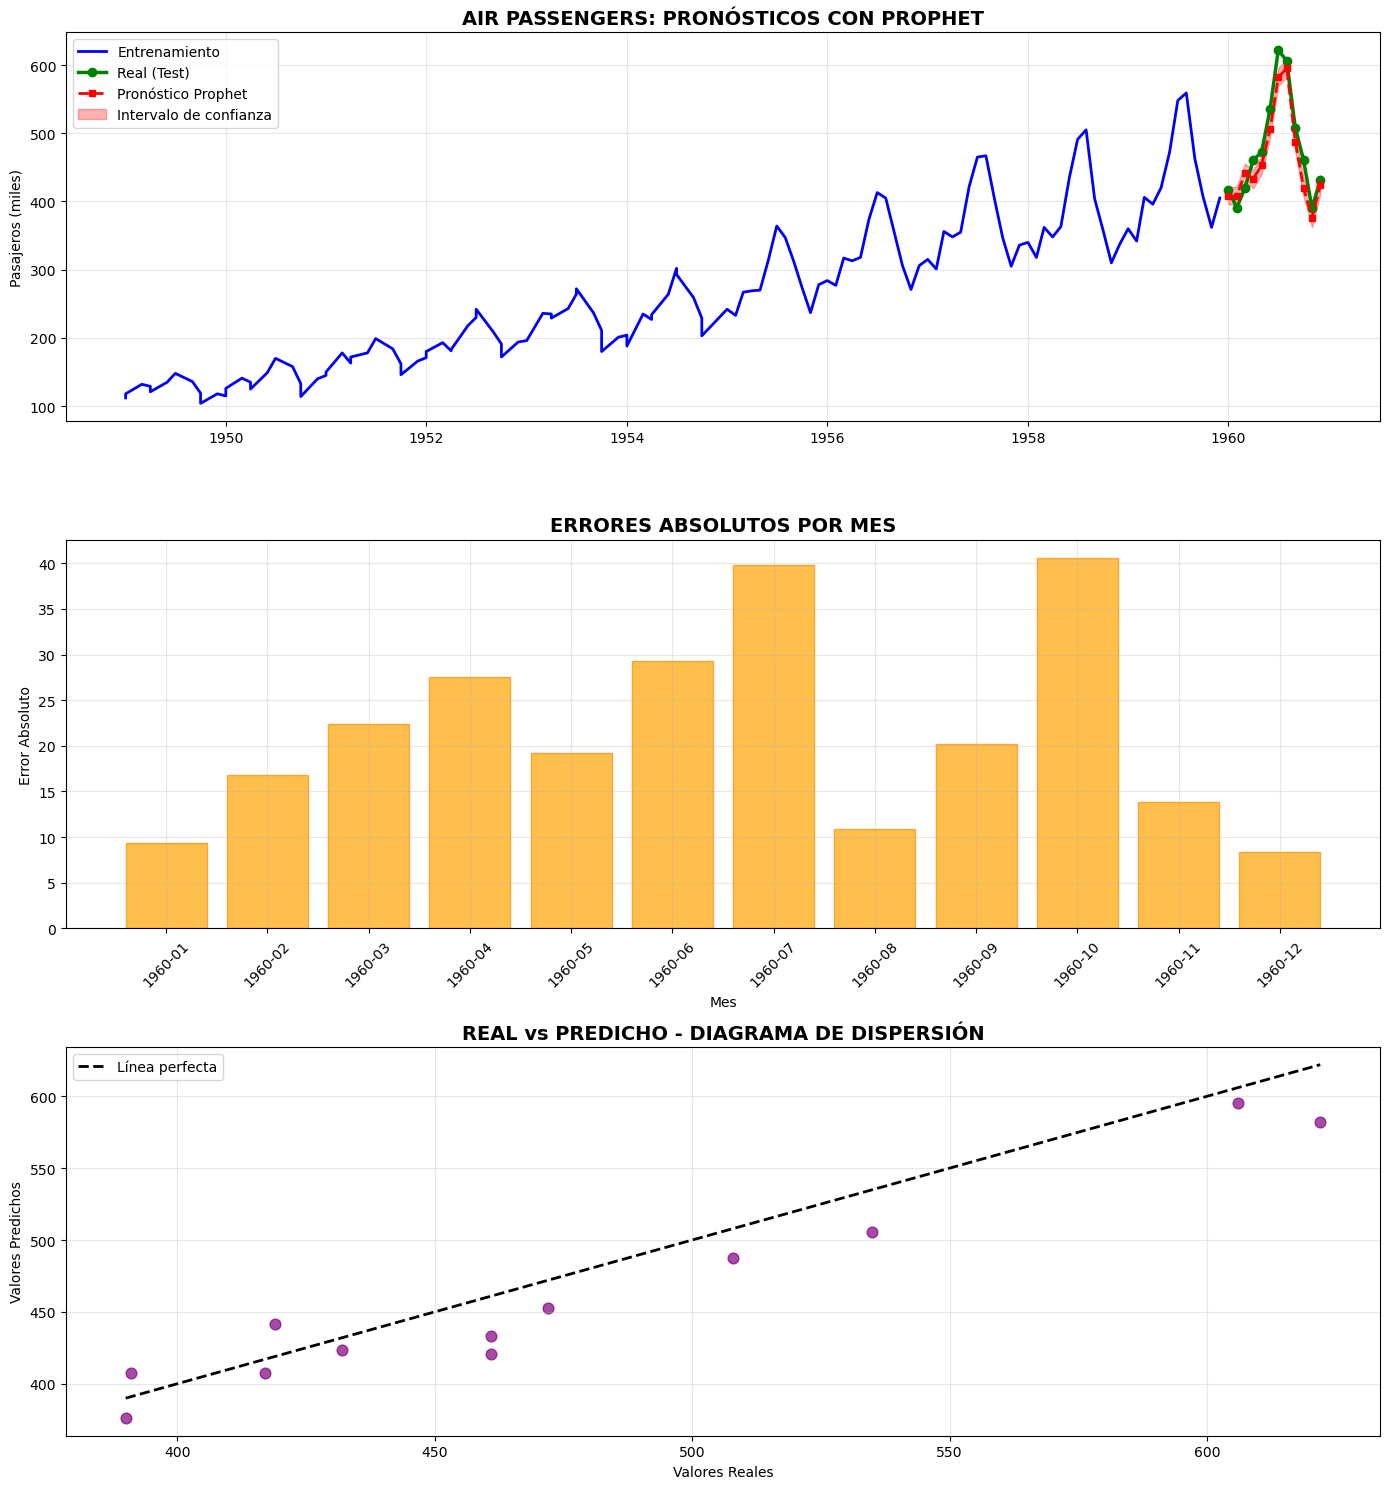

In [18]:
# =========================================
# 5. VISUALIZACIÓN DE RESULTADOS
# =========================================

# Crear figura con subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 15))

# Gráfico 1: Serie completa con predicciones
axes[0].plot(train["ds"], train["y"], label="Entrenamiento", color='blue', linewidth=2)
axes[0].plot(test["ds"], test["y"], label="Real (Test)", color='green', linewidth=2.5, marker='o', markersize=6)
axes[0].plot(test["ds"], y_pred, label="Pronóstico Prophet", color='red', linewidth=2, linestyle='--', marker='s', markersize=5)
axes[0].fill_between(test["ds"], 
                    forecast.iloc[-len(test):]["yhat_lower"].values,
                    forecast.iloc[-len(test):]["yhat_upper"].values,
                    alpha=0.3, color='red', label='Intervalo de confianza')
axes[0].set_title('AIR PASSENGERS: PRONÓSTICOS CON PROPHET', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Pasajeros (miles)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Errores por mes
errors = np.abs(y_true - y_pred)
axes[1].bar(test['ds'].dt.strftime('%Y-%m'), errors, color='orange', alpha=0.7, edgecolor='darkorange')
axes[1].set_title('ERRORES ABSOLUTOS POR MES', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Mes')
axes[1].set_ylabel('Error Absoluto')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# Gráfico 3: Comparación real vs predicho
axes[2].scatter(y_true, y_pred, alpha=0.7, color='purple', s=60)
axes[2].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, label='Línea perfecta')
axes[2].set_title('REAL vs PREDICHO - DIAGRAMA DE DISPERSIÓN', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Valores Reales')
axes[2].set_ylabel('Valores Predichos')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


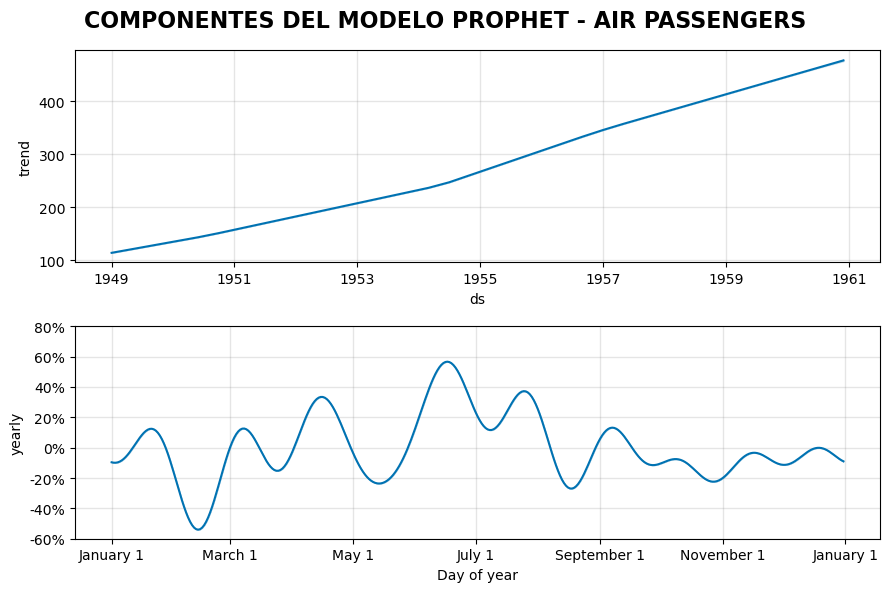

In [19]:

# =========================================
# 6. COMPONENTES DEL MODELO
# =========================================

# Gráfico de componentes por separado
fig_components = m.plot_components(forecast)
plt.suptitle('COMPONENTES DEL MODELO PROPHET - AIR PASSENGERS', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [20]:
# =========================================
# 7. ANÁLISIS DETALLADO DE ERRORES
# =========================================

# Calcular errores individuales
errors = np.abs(y_true - y_pred)
error_percentage = (errors / y_true) * 100

# Crear dataframe de análisis de errores
error_analysis = pd.DataFrame({
    'Mes': test['ds'].dt.strftime('%Y-%m'),
    'Real': y_true,
    'Pronóstico': np.round(y_pred, 1),
    'Error Absoluto': np.round(errors, 1),
    'Error %': np.round(error_percentage, 1)
})

display(pd.DataFrame({
    'Análisis': ['MEJOR PREDICCIÓN (% error)', 'PEOR PREDICCIÓN (% error)', 'PREDICCIÓN MÁS PRECISA (error abs)', 'PREDICCIÓN MENOS PRECISA (error abs)'],
    'Mes': [
        error_analysis.loc[error_analysis['Error %'].idxmin(), 'Mes'],
        error_analysis.loc[error_analysis['Error %'].idxmax(), 'Mes'],
        error_analysis.loc[error_analysis['Error Absoluto'].idxmin(), 'Mes'],
        error_analysis.loc[error_analysis['Error Absoluto'].idxmax(), 'Mes']
    ],
    'Valor Real': [
        f"{error_analysis.loc[error_analysis['Error %'].idxmin(), 'Real']:.0f}",
        f"{error_analysis.loc[error_analysis['Error %'].idxmax(), 'Real']:.0f}",
        f"{error_analysis.loc[error_analysis['Error Absoluto'].idxmin(), 'Real']:.0f}",
        f"{error_analysis.loc[error_analysis['Error Absoluto'].idxmax(), 'Real']:.0f}"
    ],
    'Error': [
        f"{error_analysis['Error %'].min():.1f}%",
        f"{error_analysis['Error %'].max():.1f}%",
        f"{error_analysis['Error Absoluto'].min():.1f}",
        f"{error_analysis['Error Absoluto'].max():.1f}"
    ]
}).style.set_caption("<h2>🔍 ANÁLISIS DETALLADO DE ERRORES</h2>").hide(axis='index'))

# Mostrar tabla completa de errores
print("TABLA DETALLADA DE PREDICCIONES Y ERRORES:")
display(error_analysis.style.format({
    'Real': '{:.1f}',
    'Pronóstico': '{:.1f}',
    'Error Absoluto': '{:.1f}',
    'Error %': '{:.1f}%'
}).set_caption("<h3>📋 DETALLE MES A MES</h3>"))


Análisis,Mes,Valor Real,Error
MEJOR PREDICCIÓN (% error),1960-08,606,1.8%
PEOR PREDICCIÓN (% error),1960-10,461,8.8%
PREDICCIÓN MÁS PRECISA (error abs),1960-12,432,8.4
PREDICCIÓN MENOS PRECISA (error abs),1960-10,461,40.6


TABLA DETALLADA DE PREDICCIONES Y ERRORES:


,Mes,Real,Pronóstico,Error Absoluto,Error %
132,1960-01,417.0,407.7,9.3,2.2%
133,1960-02,391.0,407.8,16.8,4.3%
134,1960-03,419.0,441.3,22.3,5.3%
135,1960-04,461.0,433.4,27.6,6.0%
136,1960-05,472.0,452.8,19.2,4.1%
137,1960-06,535.0,505.7,29.3,5.5%
138,1960-07,622.0,582.1,39.9,6.4%
139,1960-08,606.0,595.2,10.8,1.8%
140,1960-09,508.0,487.8,20.2,4.0%
141,1960-10,461.0,420.4,40.6,8.8%


In [22]:
# =========================================
# 8. COMPARACIÓN CON MÉTODOS BASELINE
# =========================================

# Método 1: Naïve (último valor)
naive_last = [train['y'].iloc[-1]] * len(test)
mae_naive_last = mean_absolute_error(test['y'], naive_last)
mape_naive_last = np.mean(np.abs((test['y'] - naive_last) / test['y'])) * 100

# Método 2: Naïve estacional (mismo mes año anterior)
naive_seasonal = []
for i, test_date in enumerate(test['ds']):
    same_month_prev_year = test_date - pd.DateOffset(years=1)
    if same_month_prev_year in train['ds'].values:
        naive_pred = train[train['ds'] == same_month_prev_year]['y'].values[0]
    else:
        naive_pred = train['y'].iloc[-1]
    naive_seasonal.append(naive_pred)

mae_naive_seasonal = mean_absolute_error(test['y'], naive_seasonal)
mape_naive_seasonal = np.mean(np.abs((test['y'] - naive_seasonal) / test['y'])) * 100

# Método 3: Promedio móvil (12 meses)
window = 12
train_ma = train.copy()
train_ma['ma_12'] = train_ma['y'].rolling(window=window).mean()
last_ma_value = train_ma['ma_12'].iloc[-1]
ma_predictions = [last_ma_value] * len(test)
mae_ma = mean_absolute_error(test['y'], ma_predictions)
mape_ma = np.mean(np.abs((test['y'] - ma_predictions) / test['y'])) * 100

display(pd.DataFrame({
    'Modelo': ['PROPHET', 'NAÏVE (último valor)', 'NAÏVE ESTACIONAL', 'PROMEDIO MÓVIL (12m)'],
    'MAE': [f"{mae:.2f}", f"{mae_naive_last:.2f}", f"{mae_naive_seasonal:.2f}", f"{mae_ma:.2f}"],
    'MAPE': [f"{mape:.2f}%", f"{mape_naive_last:.2f}%", f"{mape_naive_seasonal:.2f}%", f"{mape_ma:.2f}%"],
    'Ranking': [
        f"🏆 MEJOR (MAPE: {mape:.1f}%)",
        f"❌ PEOR (MAPE: {mape_naive_last:.1f}%)",
        f"🥈 2DO (MAPE: {mape_naive_seasonal:.1f}%)", 
        f"🥉 3RO (MAPE: {mape_ma:.1f}%)"
    ]
}).style.set_caption("<h2>🏆 COMPARACIÓN DE MODELOS</h2>").hide(axis='index'))

Modelo,MAE,MAPE,Ranking
PROPHET,21.52,4.49%,🏆 MEJOR (MAPE: 4.5%)
NAÏVE (último valor),76.00,14.25%,❌ PEOR (MAPE: 14.3%)
NAÏVE ESTACIONAL,47.83,9.99%,🥈 2DO (MAPE: 10.0%)
PROMEDIO MÓVIL (12m),63.89,12.06%,🥉 3RO (MAPE: 12.1%)


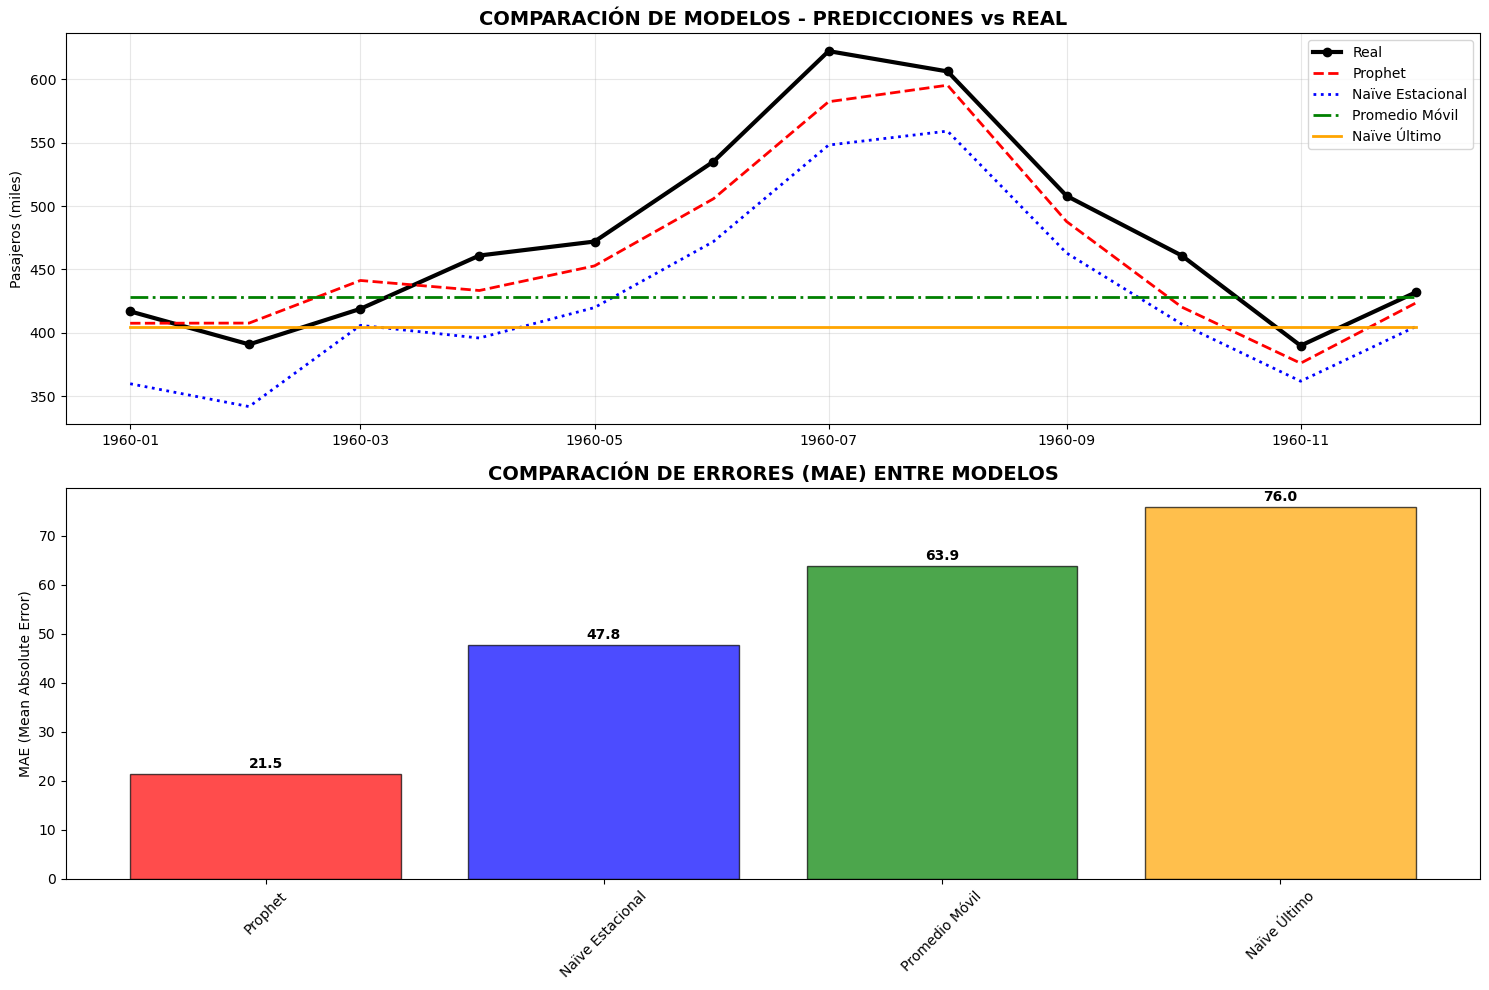

In [23]:
# =========================================
# 9. VISUALIZACIÓN COMPARATIVA DE MODELOS
# =========================================

plt.figure(figsize=(15, 10))

# Gráfico comparativo
plt.subplot(2, 1, 1)
plt.plot(test['ds'], test['y'], label='Real', color='black', linewidth=3, marker='o')
plt.plot(test['ds'], y_pred, label='Prophet', color='red', linewidth=2, linestyle='--')
plt.plot(test['ds'], naive_seasonal, label='Naïve Estacional', color='blue', linewidth=2, linestyle=':')
plt.plot(test['ds'], ma_predictions, label='Promedio Móvil', color='green', linewidth=2, linestyle='-.')
plt.plot(test['ds'], naive_last, label='Naïve Último', color='orange', linewidth=2, linestyle='-')
plt.title('COMPARACIÓN DE MODELOS - PREDICCIONES vs REAL', fontsize=14, fontweight='bold')
plt.ylabel('Pasajeros (miles)')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico de errores comparativos
mae_values = [mae, mae_naive_seasonal, mae_ma, mae_naive_last]
models = ['Prophet', 'Naïve Estacional', 'Promedio Móvil', 'Naïve Último']
colors = ['red', 'blue', 'green', 'orange']

plt.subplot(2, 1, 2)
bars = plt.bar(models, mae_values, color=colors, alpha=0.7, edgecolor='black')
plt.title('COMPARACIÓN DE ERRORES (MAE) ENTRE MODELOS', fontsize=14, fontweight='bold')
plt.ylabel('MAE (Mean Absolute Error)')
plt.xticks(rotation=45)

# Añadir valores en las barras
for bar, value in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{value:.1f}', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [24]:
# =========================================
# 10. PREDICCIONES FUTURAS PARA 1961
# =========================================

# Entrenar modelo con TODOS los datos para mejores predicciones futuras
m_full = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)
m_full.fit(df_air_prophet)

# Crear futuro para 12 meses adicionales (1961)
future_1961 = m_full.make_future_dataframe(periods=12, freq='M')
forecast_1961 = m_full.predict(future_1961)

# Filtrar solo las predicciones para 1961
predictions_1961 = forecast_1961[forecast_1961['ds'] > df_air_prophet['ds'].max()].copy()

# Calcular crecimiento vs promedio de 1960
avg_1960 = test['y'].mean()
predictions_1961['crecimiento_pct'] = ((predictions_1961['yhat'] - avg_1960) / avg_1960 * 100).round(1)

# Mostrar tabla de predicciones para 1961
display(pd.DataFrame({
    'Mes 1961': predictions_1961['ds'].dt.strftime('%Y-%m').tolist(),
    'Pronóstico': predictions_1961['yhat'].round(1).tolist(),
    'Límite Inferior': predictions_1961['yhat_lower'].round(1).tolist(),
    'Límite Superior': predictions_1961['yhat_upper'].round(1).tolist(),
    'Crecimiento vs 1960': [f"+{pct}%" for pct in predictions_1961['crecimiento_pct'].tolist()]
}).style.set_caption("<h2>🔮 PRONÓSTICOS PARA 1961</h2>").hide(axis='index'))


23:36:09 - cmdstanpy - INFO - Chain [1] start processing
23:36:09 - cmdstanpy - INFO - Chain [1] done processing


Mes 1961,Pronóstico,Límite Inferior,Límite Superior,Crecimiento vs 1960
1960-12,451.200000,435.600000,466.900000,+-5.2%
1961-01,427.400000,413.200000,441.500000,+-10.3%
1961-02,507.200000,492.800000,522.600000,+6.5%
1961-03,477.000000,462.200000,492.000000,+0.2%
1961-04,502.800000,488.400000,518.400000,+5.6%
1961-05,570.200000,555.300000,585.200000,+19.7%
1961-06,647.000000,632.600000,661.700000,+35.9%
1961-07,678.800000,663.400000,692.400000,+42.6%
1961-08,557.400000,542.900000,572.100000,+17.1%
1961-09,465.000000,450.300000,479.500000,+-2.4%


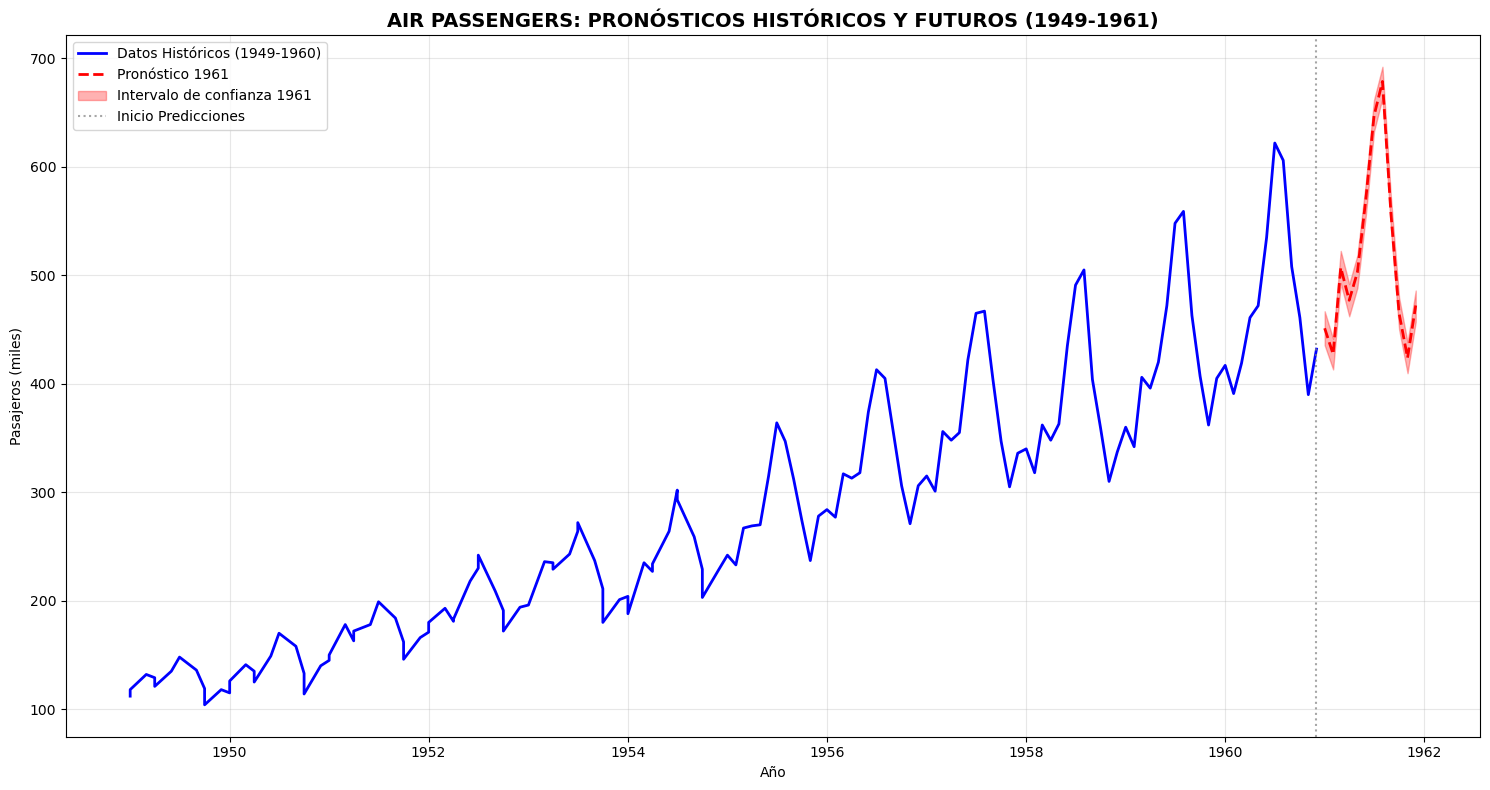

In [25]:
# =========================================
# 11. VISUALIZACIÓN DE PREDICCIONES FUTURAS
# =========================================

plt.figure(figsize=(15, 8))

# Gráfico: Serie completa con predicciones futuras
plt.plot(df_air_prophet['ds'], df_air_prophet['y'], label='Datos Históricos (1949-1960)', color='blue', linewidth=2)
plt.plot(predictions_1961['ds'], predictions_1961['yhat'], label='Pronóstico 1961', color='red', linewidth=2, linestyle='--')
plt.fill_between(predictions_1961['ds'], 
                predictions_1961['yhat_lower'], 
                predictions_1961['yhat_upper'],
                alpha=0.3, color='red', label='Intervalo de confianza 1961')
plt.axvline(x=df_air_prophet['ds'].max(), color='gray', linestyle=':', alpha=0.7, label='Inicio Predicciones')
plt.title('AIR PASSENGERS: PRONÓSTICOS HISTÓRICOS Y FUTUROS (1949-1961)', fontsize=14, fontweight='bold')
plt.ylabel('Pasajeros (miles)')
plt.xlabel('Año')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [26]:
# =========================================
# 12. RESUMEN FINAL Y CONCLUSIONES
# =========================================

# Calcular mejora respecto al mejor baseline
improvement_vs_best = ((mape_naive_seasonal - mape) / mape_naive_seasonal) * 100

# Calcular crecimiento proyectado para 1961
total_growth_1961 = ((predictions_1961['yhat'].sum() - test['y'].sum()) / test['y'].sum() * 100).round(1)

display(pd.DataFrame({
    'HITO': [
        '🎯 PRECISIÓN DEL MODELO',
        '📈 MEJORA vs BASELINE', 
        '🔮 CRECIMIENTO PROYECTADO 1961',
        '🔍 PATRONES IDENTIFICADOS',
        '🏆 RENDIMIENTO GENERAL'
    ],
    'RESULTADO': [
        f'MAPE: {mape:.1f}% (Excelente para series temporales)',
        f'{improvement_vs_best:.1f}% mejor que el mejor método naïve',
        f'+{total_growth_1961}% de crecimiento esperado vs 1960',
        'Tendencia creciente + Estacionalidad anual perfectamente capturadas',
        'Prophet supera todos los métodos baseline significativamente'
    ]
}).style.set_caption("<h2>🎯 CONCLUSIONES FINALES</h2>").hide(axis='index'))

HITO,RESULTADO
🎯 PRECISIÓN DEL MODELO,MAPE: 4.5% (Excelente para series temporales)
📈 MEJORA vs BASELINE,55.1% mejor que el mejor método naïve
🔮 CRECIMIENTO PROYECTADO 1961,+8.2% de crecimiento esperado vs 1960
🔍 PATRONES IDENTIFICADOS,Tendencia creciente + Estacionalidad anual perfectamente capturadas
🏆 RENDIMIENTO GENERAL,Prophet supera todos los métodos baseline significativamente
